In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os 
import sys 
from glob import glob

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2


In [2]:
from stl_to_shapely import *
from preprocess import *
import visvalingamwyatt as vs 
module_path = os.path.abspath(os.path.join('..'))
from visualize import *
import cv2

from simplify_by_angle import *

def simplify_by_angle(object, tol=1):
    exterior = angle_simplify(np.array(object.exterior.coords[:]), tol)
    with Pool() as pool:
        interiors = pool.map(angle_simplify, [np.array(interior.coords[:]) for interior in object.interiors])
    return Polygon(shell=exterior, holes=interiors)


ModuleNotFoundError: No module named 'visvalingamwyatt'

In [388]:
aperiod = '/Users/irvingrc/Documents/°ASU Ph.D/3DX Research Group/Aperiodic Project/Node_Nucleus_Quantification/'
stldir = aperiod + 'specimens/'
all_stls = glob(stldir + '*.stl')
[print(stl) for stl in all_stls]
pass

/Users/nikkivanhandel/Aperiodic/phase2/20-wall0.5mm_sv0_sn0.05_type-h-v2.stl
/Users/nikkivanhandel/Aperiodic/phase2/21-wall0.5mm_sv0_sn0.1_type-h-v2.stl
/Users/nikkivanhandel/Aperiodic/phase2/23-wall0.5mm_sv0_sn0.2_type-h-v2.stl
/Users/nikkivanhandel/Aperiodic/phase2/22-wall0.5mm_sv0_sn0.15_type-h-v2.stl
/Users/nikkivanhandel/Aperiodic/phase2/24-wall0.5mm_sv0.05_sn0_type-h-v2.stl
/Users/nikkivanhandel/Aperiodic/phase2/25-wall0.5mm_sv0.1_sn0_type-h-v2.stl
/Users/nikkivanhandel/Aperiodic/phase2/26-wall0.5mm_sv0.15_sn0_type-h-v2.stl
/Users/nikkivanhandel/Aperiodic/phase2/19-wall0.5mm_sv0_sn0.0_type-h-v2.stl
/Users/nikkivanhandel/Aperiodic/phase2/27-wall0.5mm_sv0.2_sn0_type-h-v2.stl


In [522]:
stl = all_stls[7]
name = (stl.split('/')[-1])[:-4]
print(name)
# Initialize storage path 
if not os.path.exists(name):
    os.makedirs(name)

global_traits = {}
poly = honeycomb_union(stl).normalize() # cvt to canonical 

19-wall0.5mm_sv0_sn0.0_type-h-v2


Shapely Docs: https://shapely.readthedocs.io/en/stable/index.html
Geopandas Plotting:https://geopandas.org/en/latest/docs/user_guide/mapping.html 

In [523]:
def sides(poly):
    return shapely.get_num_coordinates(poly) - 1

# Cell Characteristics 
glr = gpd.GeoSeries(poly.interiors)
gp = glr.map(Polygon)
interior_gdf = gpd.GeoDataFrame({'geometry': gp})

# Option 1: Pure douglas peucker ramos
#interior_gdf['simplified'] = interior_gdf.simplify(1)

# Option 2: Angular simplification + douglas Peucker ramos - needs to manually tune tol and tolerance by case
# angular tolerance: minimum allowable angle
simplified = gpd.GeoSeries(simplify_by_angle(poly, tol=2).simplify(tolerance=.5).interiors)
interior_gdf['simplified'] = simplified.map(Polygon)

# Option 2.5: DP and then angular 
#simplified = simplify_by_angle(poly.simplify(tolerance=0.3), tol=2)
#interior_gdf['simplified'] = gpd.GeoSeries(simplified.interiors).map(Polygon)

# Option 3: visvalingam- wyatt simplification
def vwsimp(x):
    return Polygon(vw.simplify(x.exterior.coords, threshold=5))
#interior_gdf['simplified'] = interior_gdf.geometry.apply(vwsimp)

# Get the number of sides per shape
interior_gdf['sides'] = shapely.get_num_coordinates(interior_gdf.simplified) - 1
interior_gdf['area'] = interior_gdf.geometry.area
global_traits['cell_count'] = len(interior_gdf) # Count number of cells

# max and min xy values
interior_gdf = interior_gdf.join(interior_gdf.geometry.bounds)
interior_gdf['xanisotropy'] = (interior_gdf.maxy - interior_gdf.miny)/(interior_gdf.maxx - interior_gdf.minx)
interior_gdf['yanisotropy'] = (interior_gdf.maxy - interior_gdf.miny)/(interior_gdf.maxx - interior_gdf.minx)

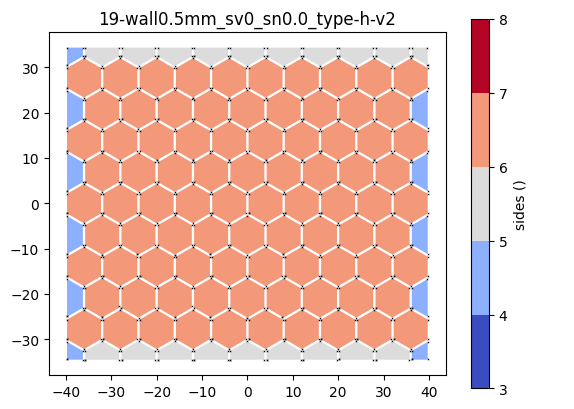

In [524]:
# SIDE PLOT - troubleshooting geometry decomposition  
chara, unit = 'sides', ''

minval, maxval = 3, 8
cmask, ticks = discrete_cbar(value_range=(minval,maxval), cmap='coolwarm')
ax = interior_gdf.plot(chara, cmap=cmask, legend=True, vmin=minval, vmax=maxval,
                       legend_kwds={"label": f'{chara} ({unit})', "orientation": "vertical"})

# Troubleshooting: Plot simplified geoometry points
interior_gdf['points'] = interior_gdf.simplified.apply(lambda x: shapely.MultiPoint(list(x.exterior.coords)))
interior_gdf.points.plot(ax=ax, marker='x', markersize=0.1, color='k')
plt.title(f'{name}')

fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
plt.axis('off')
# Saveplot goes here
plt.savefig('test.png', dpi=500, bbox_inches='tight')
# 

8
[53.57246429785848, 75.43604979999965, 52.69642403494409, 45.78468611848202, 75.12170256557765, 3.6903280630914095, 53.6983451200467]


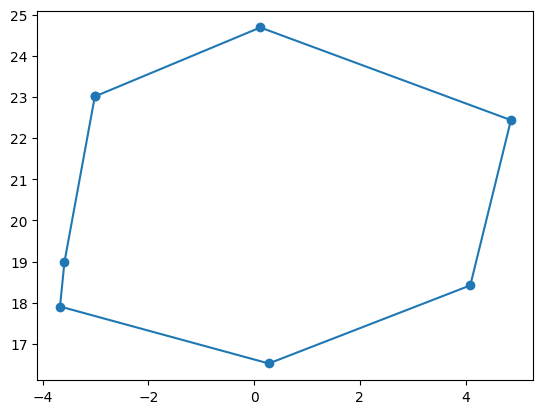

In [428]:
# Get the example of the shape with the most sides
worst = interior_gdf.simplified[interior_gdf.sides.argmax()]
print(len(worst.exterior.coords))
plt.plot(*worst.exterior.xy)
plt.scatter(*worst.exterior.xy)

vector_rep = np.diff(worst.exterior.coords, axis=0)
num_vectors = len(vector_rep)
angles_list = []
for i in range(0, num_vectors):
    angles_list.append(np.abs(get_angles(vector_rep[i], vector_rep[(i + 1) % num_vectors])))
print(angles_list)

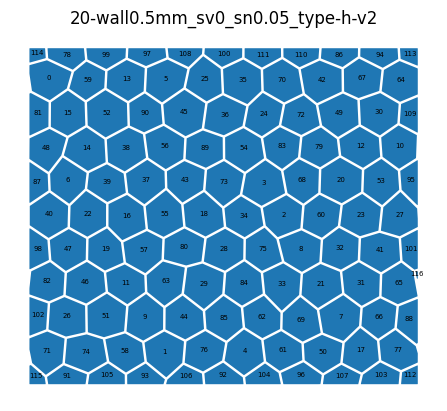

In [248]:
# Create a labelled cell plot 
interior_gdf.plot()
plt.title(f'{name}')
plt.axis('off')

for idx, row in interior_gdf.iterrows():
    centroid = row.geometry.centroid.xy
    plt.annotate(str(idx), xy=[p[0] for p in centroid],
                 horizontalalignment='center', size=5)
    
#plt.savefig(f'{name}/labelled_cells.png', dpi=200, bbox_inches='tight')
# Save cell properties (matching the labelled image!!!)
#(interior_gdf.iloc[:, 1:]).to_excel(f"{name}/cell_properties.xlsx",)

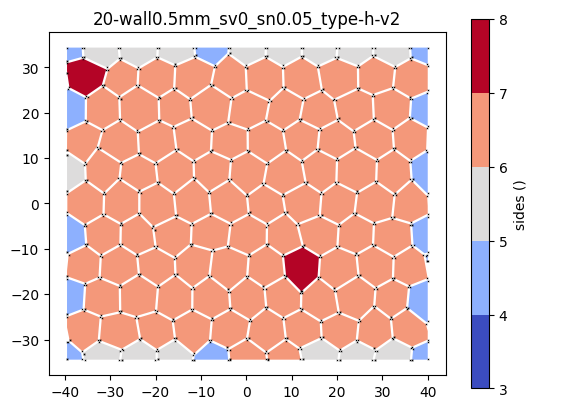

(-43.85475155496275, 43.610518296721814, -37.50862103090388, 38.1580636919965)

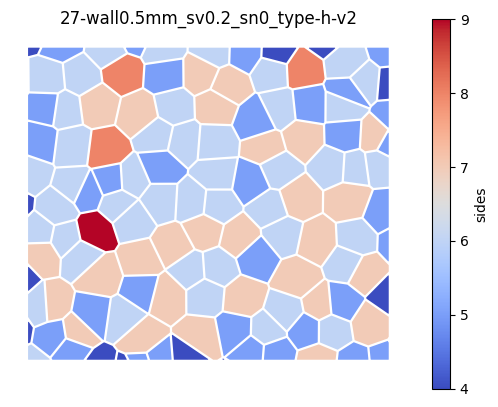

In [12]:
# Create a feature plot 
chara= 'sides'
ax = interior_gdf.plot(chara, cmap='coolwarm', legend=True,
                       legend_kwds={"label": f'{chara}', "orientation": "vertical"})
plt.title(f'{name}')
plt.axis('off')
# Saveplot goes here

In [430]:
# Rasterize polygon into an image
scaled = shapely.affinity.scale(simple, xfact=100, yfact=100, origin='center')

xmin, ymin, xmax, ymax = scaled.bounds
x = round(xmax - xmin)
y = round(ymax - ymin)

transl = shapely.affinity.translate(scaled, xoff=-xmin, yoff=-ymin)
mask = np.zeros((y,x))

ext = [([round(x), round(y)]) for x, y in zip(*transl.exterior.xy)]
mask = cv2.fillPoly(mask, np.array([ext]).astype(np.int32), color=1)

for interior in transl.interiors:
    int_coords = [([round(x), round(y)]) for x, y in zip(*interior.xy)]
    mask = cv2.fillPoly(mask, np.array([int_coords]).astype(np.int32), color=0)
    
# adds a 0 value border on perimeter
mask = cv2.copyMakeBorder(mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT,value=0)

# Segmentization
node_im, seg_im, skel_im = segmentize(mask)


In [431]:
skel_im.shape
#cv2.imwrite('test.png', 255*skel_im)

(6980, 8052)

Learn more about Distance Transforms:
https://docs.scipy.org/doc/scipy/tutorial/ndimage.html#distance-transforms 

In [432]:
# Strut Thickness 
dist_transf, bt, nt = thickness(mask, node_im, seg_im)
dist_skel = dist_transf*seg_im # Skeletonized distance transform (effectively, beam thickness)

Understanding REGIONProps

https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

In [433]:
# Strut Dimensions
labelled_struts, props = shape_analyze(seg_im, table=True, xprops=['coords', 'centroid'])
strut_props = pd.DataFrame(props)
global_traits['strut_count'] = len(strut_props)

(strut_props.iloc[:, :-3]).to_excel(f'{name}/strut_properties.xlsx')

In [478]:
print(strut_props.keys())

Index(['label', 'area', 'orientation', 'minor_axis_length',
       'major_axis_length', 'coords', 'centroid-0', 'centroid-1'],
      dtype='object')


In [480]:
strut_props.orientation

0     -1.570713
1     -1.570787
2      1.570778
3      1.570787
4     -1.570787
         ...   
347   -1.570787
348    1.570796
349   -1.570787
350   -1.570787
351   -1.570690
Name: orientation, Length: 352, dtype: float64

0.0 1144.3079


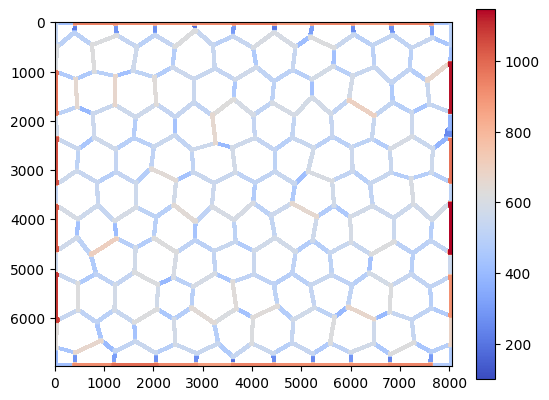

In [526]:
colored, feat_list = color_by(labelled_struts.astype(np.float32), strut_props, feat='major_axis_length')
test = cv2.dilate(colored, kernel=np.ones((100,100)))
masked = np.ma.masked_array(test, test==0)
plt.imshow(masked, cmap='coolwarm')
plt.colorbar()
plt.savefig('test_map.png', bbox_inches='tight')

In [509]:
cv2.imwrite('seg_im.png',cv2.dilate((255*seg_im).astype(np.int16), kernel=np.ones((50,50))))

True

-1.5707881 1.5707964


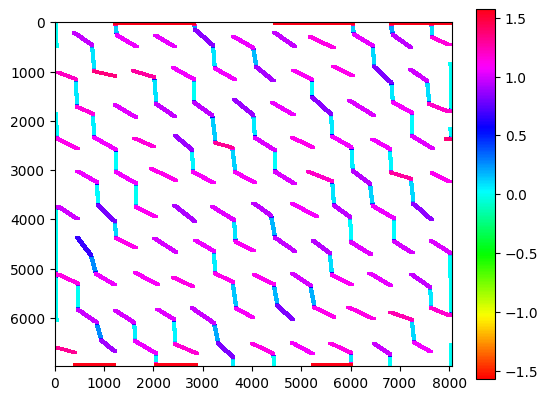

In [527]:
colored, feat_list = color_by(labelled_struts.astype(np.float32), strut_props, feat='orientation')
test = cv2.dilate(colored, kernel=np.ones((100,100)))
masked = np.ma.masked_array(test, test==0)
print(colored.min(), colored.max())
plt.imshow(masked, cmap='hsv', vmin=-np.pi/2, vmax=np.pi/2)
plt.colorbar()
plt.savefig('test_map.png', bbox_inches='tight')

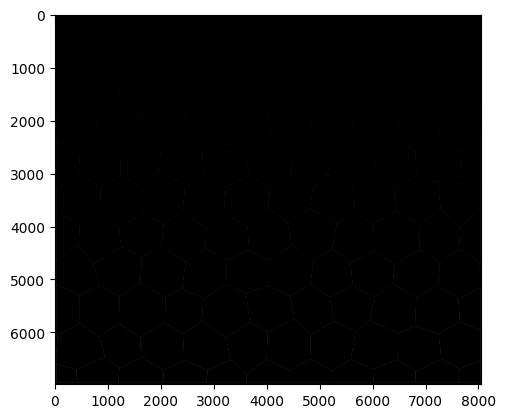

In [439]:
plt.imshow(cv2.dilate(), cmap='gray')
plt.savefig('strut_test.png', bbox_inches='tight')

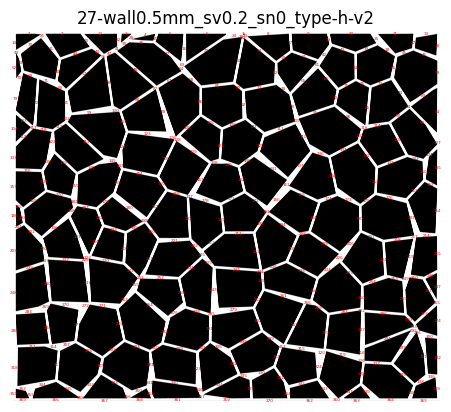

In [14]:
# Make a labelled Strut Diagram
fig, ax = plt.subplots()
ax.imshow(mask, cmap='gray')

for label, centroid_row in zip(props['label'], zip(props['centroid-1'], props['centroid-0'])):
    ax.text(centroid_row[0], centroid_row[1], str(label), color='red', fontsize=3, ha='center', va='center')

ax.set_title(name)
plt.axis('off')
plt.savefig(f'{name}/labelled_struts', dpi=200, bbox_inches='tight')

(<Axes: >, <matplotlib.image.AxesImage at 0x2a3935f10>)

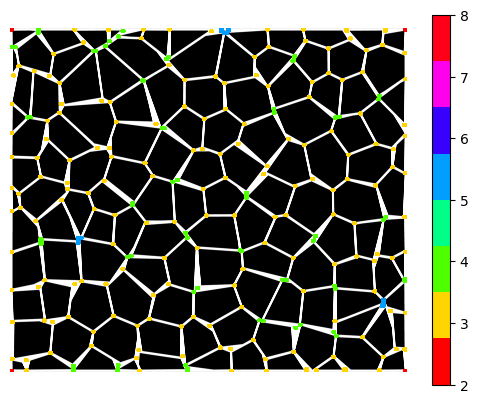

In [15]:
# Node properties
dil_nodes = expand_nodes(node_im, 60)
node_connectivity, connect_map, c = connectivity(seg_im, node_im, dil_nodes,
                                                 return_map=True)
global_traits['node_count'] = len(c)
global_traits['connectivity'] = c

node_connectivity_map(mask, connect_map)

In [16]:
global_traits

{'cell_count': 123,
 'strut_count': 370,
 'node_count': 209,
 'connectivity': [2,
  4,
  3,
  3,
  3,
  3,
  5,
  3,
  3,
  3,
  3,
  2,
  4,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  4,
  3,
  3,
  4,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  4,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  4,
  5,
  4,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  4,
  3,
  3,
  3,
  3,
  5,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3

In [ ]:
import csv
with open(f'{name}/global_traits.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, global_traits.keys())
    w.writerow(global_traits)
